<img src="https://raw.githubusercontent.com/dask/dask/main/docs/source/images/dask_horizontal_no_pad.svg" 
     width="35%"
     alt="Dask logo\" />

This notebook was inspired in the materials from: 

- https://github.com/coiled/pydata-global-dask/
- https://github.com/dask/dask-tutorial/

# Dask Delayed

Sometimes we have problems that are parallelizable. Dask delayed is an interface that can be use to parallelize existing Python code and custom algorithms. 

A first step to determine if we can use `dask.delayed` is to identify if there is some level of parallelism that we haven't exploit and hopefully `dask.delayed` will take care of it. We will start showing a simple example inspired on the main [Dask tutorial](https://tutorial.dask.org/), and we will it parallelize using `dask.delayed`.

The following two functions will perform simple computations, where we use the `sleep` to simulate work. 

In [1]:
from time import sleep

def inc(x):
    """Increments x by one"""
    sleep(1)
    return x + 1

def add(x, y):
    """Adds x and y"""
    sleep(1)
    return x + y

Let's do some operations and time these functions using the `%%time` magic at the beginning of the cell. 

In [2]:
%%time

x = inc(1)
y = inc(2)
z = add(x, y)

CPU times: user 536 µs, sys: 1.48 ms, total: 2.01 ms
Wall time: 3.01 s


The execution of the cell above took three seconds, this happens because we are calling  each function sequentially. The computations above can be represented by the following graph:

<img src="https://raw.githubusercontent.com/dask/dask/main/docs/source/images/inc-add.svg" 
     width="55%"
     alt="Dask graph\" />


Where the circles are function calls, squares represent objects that are created by one task as output and can be inputs into other tasks, and arrows represent the dependencies between the tasks. From looking at the task graph, the opportunity for parallelization is more evident since the the two calls to the `inc` function are completely independent of one-another. Let's explore how `dask.delayed` can help us with this.


### `dask.delayed` 

Using the `dask.delayed` decorator we'll transform the `inc` and `add` functions. 

In [3]:
from dask import delayed

In [4]:
%%time

a = delayed(inc)(1)
b = delayed(inc)(2)
c = delayed(add)(a, b)

CPU times: user 1.04 ms, sys: 147 µs, total: 1.19 ms
Wall time: 1.15 ms


When we call the `delayed` version of the functions by passing the arguments, the original function is isn't actually called yet, that's why the execution finishes very quickly. When we called the `delayed` version of the functions, a `delayed` object is made, which keeps track of the functions to call and what arguments to pass to it. 

If we inspect `c`, we will notice that it instead of having the value five, we have what is called a `delayed` object.

In [5]:
print(c)

Delayed('add-5bb561e0-48a4-452f-9b4c-ac5187324cfa')


We can visualize this objects by doing:

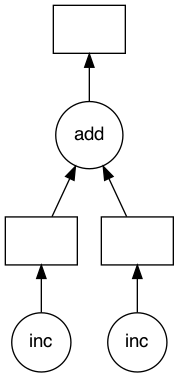

In [6]:
c.visualize()

Up to this point the object `c` holds all the information we need to compute the result. We can evaluate the result with `.compute()`.

In [7]:
%%time

c.compute()

CPU times: user 2.92 ms, sys: 3.49 ms, total: 6.41 ms
Wall time: 2.02 s


5

Notice that now the computation took 2s instead of 3s, this is because the two `inc` computations are run in parallel. 

**Note for Binder users**

If you are running this notebook using binder, you will probably not ee a speed-up. This happens because binder instances tend to have only one core with no threads so you can't see any parallelism. We can "fix" this by setting the number of workers a higher but there is no guarantee that we will get these resources. 

For now, you can try copying the following line on a cell and executing the same computation than before and see what happens. On one cell execute:


```python
import dask
dask.config.set(scheduler='threads', num_workers=4)  #setting num_workers
```

and on a separate cell try to run this again:

```python
%%time
c.compute()
```

Don't worry about the syntax for now, we will explain this on the next lesson. 

## Parallelizing a `for`-loop

When we perform the same group of operation multiple times in the form of `for-loop`, there is a chance that we can perform this computations in parallel. For example, the following serial code, can be parallelized using `delayed`: 

In [8]:
data = list(range(8))

#### Sequential code

In [9]:
%%time
results = []
for i in data:
    y = inc(i)         # do somthing here
    results.append(y)
    
total = sum(results)  # do something here

CPU times: user 1 ms, sys: 1.44 ms, total: 2.44 ms
Wall time: 8.03 s


In [10]:
print(f'{total = }')

total = 36


### Exercise: 

Notice that both the `inc` and `sum` operations can be done in parallel, use `delayed` to parallelize the sequential code above, compute the `total` and time it using `%%time` 

In [11]:
#solution
results = []
for i in data:
    y = delayed(inc)(i)    
    results.append(y)
    
total = delayed(sum)(results)  

In the code above, the `sum` step is not run in parallel, but it depends on each of the `inc` steps, that's why it needs the `delayed` decorator too. The `inc`steps will be parallelized, then aggregated with the `sum` step.

Notice that we can apply delayed to built-in functions, as we did in the case of `sum` in the code above. 

In [12]:
total

Delayed('sum-2e43300d-0cb4-4355-a115-c869a9c6eca1')

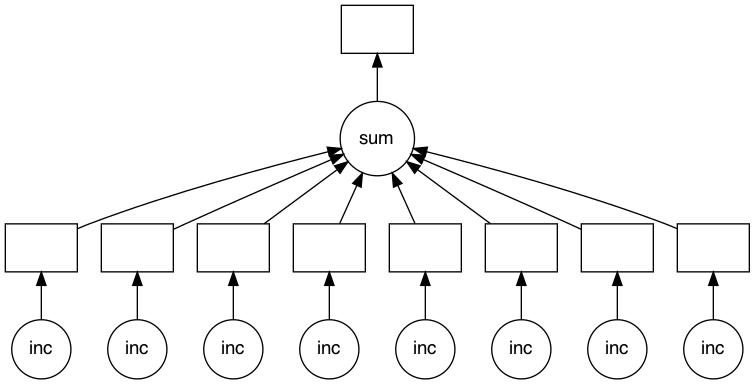

In [13]:
total.visualize()

In [14]:
%%time
total.compute()

CPU times: user 3.66 ms, sys: 2.44 ms, total: 6.1 ms
Wall time: 1.01 s


36

**Note:**

When we used `dask.delayed` without having a distributed scheduler (will see this later). We are relying on a single-machine scheduler, and dask will use the threadpool executor, which by default will use the resources available on your machine. This can cause that you see different time values for the parallel version, since it'll depend on the resources you have available.

You can check this by doing:

In [15]:
import os
os.cpu_count()

8

###  The `@delayed` syntax 

The `delayed` decorator can be also used by "decorating" with `@delayed` the function you want to parallelize.

In [16]:
@delayed                    
def double(x):
    """Decrease x by one"""
    sleep(1)
    return 2*x 

Then when we call this new `double` function we obtain a delayed object:

In [17]:
d = double(4)
print(d)

Delayed('double-61b3a352-b213-46c7-8f47-832204c22f2f')


### Exercise

Using the `delayed` decorator create the parallel versions of `inc` and `add`

In [ ]:
#solution

@delayed
def inc(x):
    """Increments x by one"""
    sleep(1)
    return x + 1

@delayed
def add(x, y):
    """Adds x and y"""
    sleep(1)
    return x + y

``Delayed`` objects support several standard Python operations, each of which creates another ``Delayed`` object representing the result:

- Arithmetic operators, e.g. `*`, `-`, `+`
- Item access and slicing, e.g. `x[0]`, `x[1:3]`
- Attribute access, e.g. `x.size`
- Method calls, e.g. `x.index(0)`

For example you can do:

In [ ]:
result = (inc(5) * inc(7)) + (inc(3) * inc(2))
result.visualize()

In [ ]:
%%time
result.compute()

## Another for-loop example 

Let's say we want to perform some operations like `inc`, `double` and `add` on a list of data, and finally aggregate all the results. We can use our `delayed` decorated functions to perform this computations faster. 
The serial version of the code below would take approximately 24 seconds, let's see how long does the parallel version takes:

In [ ]:
data = list(range(8))

output = []
for x in data:
    a = inc(x)     #parallel version
    b = double(x)  #parallel version
    c = add(a, b)  #parallel version
    output.append(c)

total = delayed(sum)(output)
total

Noticed that `inc`, `double` and `add` in the code above are already the parallel versions, since we decorated with `@delayed`

In [ ]:
total.visualize()

In [ ]:
%%time
total.compute()

## Extra resources

For more examples on `dask.delayed` check:
- Main Dask tutorial: [Delayed lesson](https://github.com/dask/dask-tutorial/blob/main/01_dask.delayed.ipynb)
- More examples on Delayed: [PyData global - Dask tutorial - Delayed](https://github.com/coiled/pydata-global-dask/blob/master/1-delayed.ipynb)
- Short screencast on Dask delayed: [How to parallelize Python code with Dask Delayed (3min)](https://www.youtube.com/watch?v=-EUlNJI2QYs)
- [Dask Delayed documentation](https://docs.dask.org/en/latest/delayed.html)
- [Delayed Best Practices](https://docs.dask.org/en/latest/delayed-best-practices.html)
